# 🔥 Building Rockpool modules with Torch

## Use the Rockpool Torch-backed classes

In [20]:
# - Switch off warnings
import warnings
warnings.filterwarnings('ignore')

# - Rich printing
try:
    from rich import print
except:
    pass

# - Import and configure matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

# - Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F

In [21]:
from rockpool.nn.modules import RateTorch, LinearTorch
from rockpool.nn.combinators import Sequential

# Define a simple feed-forward network using the Torch backend
net = Sequential(
    LinearTorch((2, 5)),
    RateTorch((5,)),
    nn.Dropout2d(0.25),
    LinearTorch((5, 2)),
    RateTorch((2,)),
)
net

TorchSequential  with shape (2, 2) {
    LinearTorch '0_LinearTorch' with shape (2, 5)
    RateTorch '1_RateTorch' with shape (5,)
    Dropout2d '2_Dropout2d' with shape (None,)
    LinearTorch '3_LinearTorch' with shape (5, 2)
    RateTorch '4_RateTorch' with shape (2,)
}

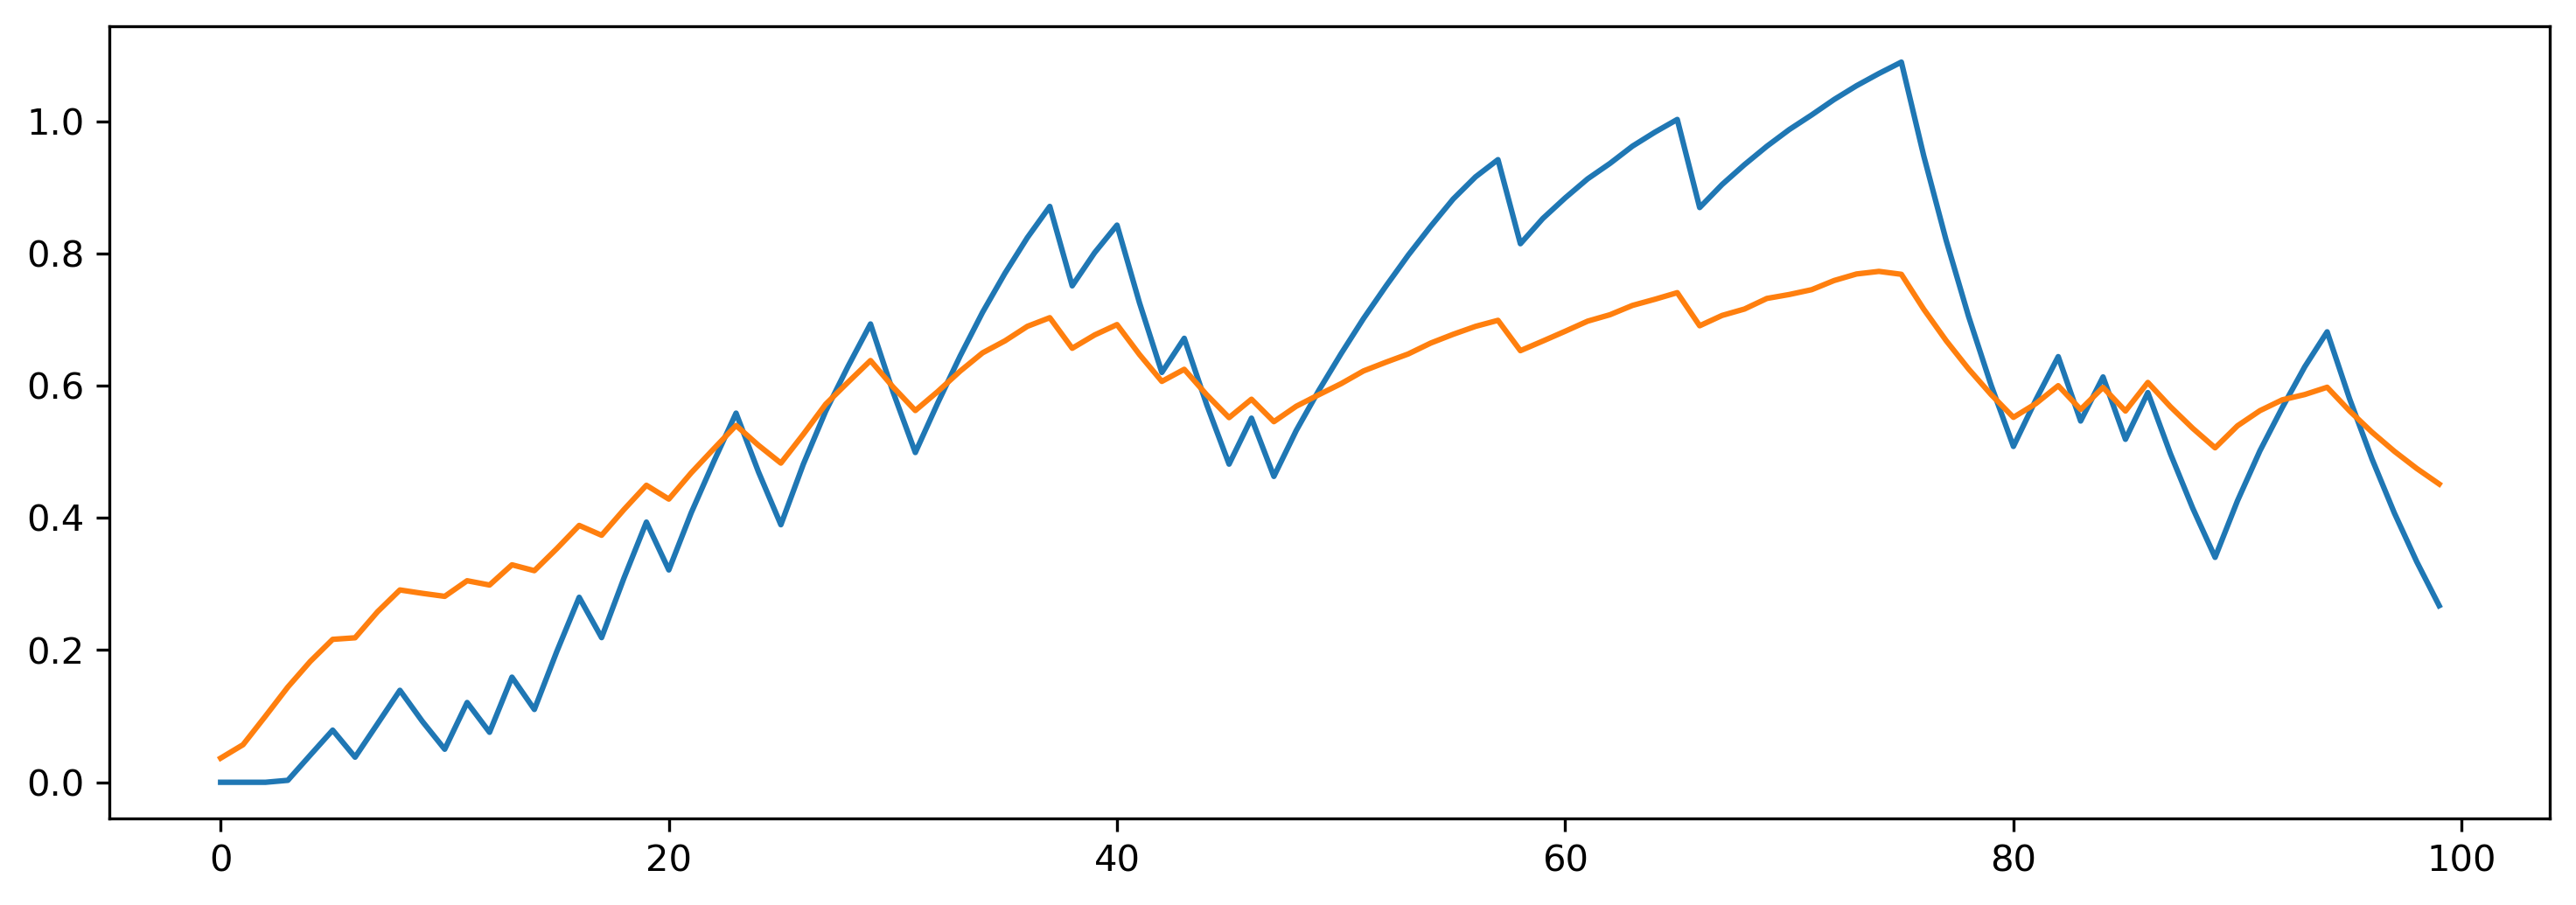

In [22]:
# - Evolve the network on ranomd data and plot
data = torch.rand((100, 2))
out, _, _ = net(data)
plt.plot(out[0].detach());

In [27]:
# - Recording internal signals also works
out, _, rd = net(data, record = True)
print(list(rd.keys()))

[
    '0_LinearTorch',
    '0_LinearTorch_output',
    '1_RateTorch',
    '1_RateTorch_output',
    '2_Dropout2d',
    '2_Dropout2d_output',
    '3_LinearTorch',
    '3_LinearTorch_output',
    '4_RateTorch',
    '4_RateTorch_output'
]

## Convert an existing Torch ``torch.nn.module`` for use in Rockpool

In [28]:
# - Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F

# - Rockpool imports
from rockpool.nn.modules import TorchModule

# - Implement a Torch class
class TorchNet(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # - Build some convolutional layers
        self.conv1 = nn.Conv2d(1, 2, 3, 1)
        
        # - Add a dropout layer
        self.dropout1 = nn.Dropout2d(0.25)
        
        # - Fully-connected layer
        self.fc1 = nn.Linear(338, 10)
        
        # - Register an example buffer
        self.register_buffer('test_buf', torch.zeros(3, 4))
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = F.relu(x)
        
        output = F.log_softmax(x, dim = 1)
        return output

In [29]:
# - Instantiate the network and test the Torch API

# Equates to one random 28x28 image
random_data = torch.rand((1, 1, 28, 28))

# - Generate torch module and test evaluation
mod = TorchNet()
result = mod(random_data)

[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


In [30]:
# - Convert object to Rockpool API, in-place
TorchModule.from_torch(mod)
print(mod)

TorchNet 'TorchModulePatch' with shape (None,) {
    Conv2d 'TorchModulePatch' with shape (None,)
    Dropout2d 'TorchModulePatch' with shape (None,)
    Linear 'TorchModulePatch' with shape (None,)
}

In [31]:
# - Use the Rockpool API to evolve the module
output, _, _ = mod(random_data)
print(output)

tensor([[-2.3065, -2.2867, -2.3189, -2.2665, -2.3046, -2.3099, -2.3189, -2.3092,
         -2.2872, -2.3189]], grad_fn=<LogSoftmaxBackward0>)

In [32]:
# - Use the Rockpool API to access parameters
print('Parameters: ', mod.parameters())
print('State: ', mod.state())

Parameters: 
{
    'conv1': {
        'weight': Parameter containing:
tensor([[[[ 0.1237,  0.2295,  0.0553],
          [-0.0433,  0.0800, -0.2576],
          [ 0.1955, -0.2917, -0.2537]]],


        [[[ 0.3292,  0.1458,  0.3166],
          [-0.0364, -0.2260,  0.2632],
          [-0.0643, -0.1588, -0.0217]]]], requires_grad=True),
        'bias': Parameter containing:
tensor([-0.2496, -0.0705], requires_grad=True)
    },
    'dropout1': {},
    'fc1': {
        'weight': Parameter containing:
tensor([[ 0.0419, -0.0253, -0.0354,  ...,  0.0188, -0.0005,  0.0233],
        [ 0.0018,  0.0232, -0.0490,  ...,  0.0243, -0.0219, -0.0179],
        [-0.0190, -0.0390,  0.0397,  ...,  0.0432, -0.0114,  0.0137],
        ...,
        [ 0.0541, -0.0494, -0.0519,  ..., -0.0235, -0.0455, -0.0521],
        [-0.0370, -0.0098,  0.0524,  ..., -0.0274, -0.0465,  0.0096],
        [-0.0098,  0.0510,  0.0358,  ...,  0.0087,  0.0499,  0.0120]],
       requires_grad=True),
        'bias': Parameter containing:
tensor([ 0.0175,  0.0208,  0.0009,  0.0525,  0.0219,  0.0063, -0.0347,  0.0213,
         0.0372, -0.0449], requires_grad=True)
    }
}

State: 
{
    'test_buf': tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
    'conv1': {},
    'dropout1': {},
    'fc1': {}
}

In [33]:
# - Convert the parameter dictionary to torch parameters
print('Parameters.astorch(): ', list(mod.parameters().astorch()))

Parameters.astorch(): 
[
    Parameter containing:
tensor([[[[ 0.1237,  0.2295,  0.0553],
          [-0.0433,  0.0800, -0.2576],
          [ 0.1955, -0.2917, -0.2537]]],


        [[[ 0.3292,  0.1458,  0.3166],
          [-0.0364, -0.2260,  0.2632],
          [-0.0643, -0.1588, -0.0217]]]], requires_grad=True),
    Parameter containing:
tensor([-0.2496, -0.0705], requires_grad=True),
    Parameter containing:
tensor([[ 0.0419, -0.0253, -0.0354,  ...,  0.0188, -0.0005,  0.0233],
        [ 0.0018,  0.0232, -0.0490,  ...,  0.0243, -0.0219, -0.0179],
        [-0.0190, -0.0390,  0.0397,  ...,  0.0432, -0.0114,  0.0137],
        ...,
        [ 0.0541, -0.0494, -0.0519,  ..., -0.0235, -0.0455, -0.0521],
        [-0.0370, -0.0098,  0.0524,  ..., -0.0274, -0.0465,  0.0096],
        [-0.0098,  0.0510,  0.0358,  ...,  0.0087,  0.0499,  0.0120]],
       requires_grad=True),
    Parameter containing:
tensor([ 0.0175,  0.0208,  0.0009,  0.0525,  0.0219,  0.0063, -0.0347,  0.0213,
         0.0372, -0.0449], requires_grad=True)
]

## Write a native Rockpool/Torch module using ``TorchModule``

In [34]:
# - Implement a Rockpool class using the TorchModule base class
class RockpoolNet(TorchModule):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # - Build some convolutional layers
        self.conv1 = nn.Conv2d(1, 2, 3, 1)
        
        # - Add a dropout layer
        self.dropout1 = nn.Dropout2d(0.25)
        
        # - Fully-connected layer
        self.fc1 = nn.Linear(338, 10)
        
        # - Register an example buffer
        self.register_buffer('test_buf', torch.zeros(3, 4))

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = F.relu(x)
        
        output = F.log_softmax(x, dim = 1)
        return output

In [35]:
# - Instantiate the Rockpool class directly
rmod = RockpoolNet()
print(rmod)

RockpoolNet  with shape (None,) {
    Conv2d 'conv1' with shape (None,)
    Conv2d 'conv1' with shape (None,)
    Dropout2d 'dropout1' with shape (None,)
    Dropout2d 'dropout1' with shape (None,)
    Linear 'fc1' with shape (None,)
    Linear 'fc1' with shape (None,)
}

In [36]:
# - Evaluate the module using the Rockpool API
output, _, _ = rmod(random_data)
print(output)

tensor([[-2.2228, -2.3020, -2.3444, -2.3219, -2.3444, -2.3444, -2.3444, -2.3444,
         -2.2281, -2.2414]], grad_fn=<LogSoftmaxBackward0>)

In [37]:
# - Access parameters using the Rockpool API
print('Parameters: ', rmod.parameters())
print('State: ', rmod.state())

Parameters: 
{
    'conv1': {
        'weight': Parameter containing:
tensor([[[[-0.0005, -0.1798, -0.3329],
          [-0.1329,  0.2385, -0.0800],
          [-0.0545,  0.1831,  0.0707]]],


        [[[ 0.0102, -0.2320,  0.3216],
          [ 0.2575, -0.2884,  0.2851],
          [ 0.1376,  0.2057,  0.2560]]]], requires_grad=True),
        'bias': Parameter containing:
tensor([-0.2206, -0.2983], requires_grad=True)
    },
    'dropout1': {},
    'fc1': {
        'weight': Parameter containing:
tensor([[-0.0342,  0.0518, -0.0296,  ..., -0.0115,  0.0214, -0.0188],
        [-0.0321,  0.0220,  0.0182,  ..., -0.0184, -0.0415,  0.0157],
        [-0.0135,  0.0050,  0.0309,  ..., -0.0534,  0.0167,  0.0200],
        ...,
        [ 0.0317,  0.0288, -0.0353,  ...,  0.0266, -0.0360,  0.0313],
        [ 0.0047, -0.0430,  0.0090,  ..., -0.0295,  0.0231, -0.0266],
        [-0.0389,  0.0183,  0.0497,  ..., -0.0258,  0.0534, -0.0399]],
       requires_grad=True),
        'bias': Parameter containing:
tensor([ 0.0270, -0.0178, -0.0513,  0.0416,  0.0315, -0.0121, -0.0244, -0.0496,
         0.0467,  0.0480], requires_grad=True)
    }
}

State: 
{
    'test_buf': tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
    'conv1': {},
    'dropout1': {},
    'fc1': {}
}

## Converting from Rockpool/torch to pure torch

### Rockpool API

In [44]:
# - Instantiate the Rockpool class
net = RockpoolNet()
print(net)

RockpoolNet  with shape (None,) {
    Conv2d 'conv1' with shape (None,)
    Conv2d 'conv1' with shape (None,)
    Dropout2d 'dropout1' with shape (None,)
    Dropout2d 'dropout1' with shape (None,)
    Linear 'fc1' with shape (None,)
    Linear 'fc1' with shape (None,)
}

In [45]:
# - Rockpool dictionary-based parameter API
print('Parameters:', net.parameters())

Parameters:
{
    'conv1': {
        'weight': Parameter containing:
tensor([[[[ 0.2291,  0.2318,  0.1086],
          [-0.0561,  0.1448, -0.0028],
          [ 0.1515, -0.1789, -0.1643]]],


        [[[ 0.0935, -0.2185, -0.2043],
          [-0.0392,  0.0172, -0.1516],
          [-0.1450, -0.2613, -0.0803]]]], requires_grad=True),
        'bias': Parameter containing:
tensor([-0.3084,  0.0496], requires_grad=True)
    },
    'dropout1': {},
    'fc1': {
        'weight': Parameter containing:
tensor([[-0.0259, -0.0517,  0.0194,  ..., -0.0191, -0.0532, -0.0077],
        [-0.0433,  0.0126, -0.0323,  ...,  0.0053, -0.0495, -0.0165],
        [-0.0025, -0.0103, -0.0365,  ...,  0.0439,  0.0347,  0.0281],
        ...,
        [-0.0184, -0.0059,  0.0474,  ...,  0.0188,  0.0302,  0.0241],
        [ 0.0401,  0.0111, -0.0326,  ...,  0.0347, -0.0327,  0.0446],
        [-0.0508,  0.0017,  0.0408,  ...,  0.0434,  0.0269,  0.0398]],
       requires_grad=True),
        'bias': Parameter containing:
tensor([ 0.0007,  0.0420, -0.0319,  0.0443,  0.0423, -0.0233,  0.0411,  0.0423,
         0.0356,  0.0369], requires_grad=True)
    }
}

In [51]:
# Evaluate one random 28x28 image
random_data = torch.rand((1, 1, 28, 28))

# - Rockpool standard calling semantics
print(net(random_data))

(
    tensor([[-2.3147, -2.2631, -2.3147, -2.3147, -2.2558, -2.3147, -2.3147, -2.3066,
         -2.3147, -2.3147]], grad_fn=<LogSoftmaxBackward0>),
    {
        'test_buf': tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
        'conv1': {},
        'dropout1': {},
        'fc1': {}
    },
    {}
)

### Torch API

In [52]:
# - Convert in-place to the pure Torch API
net.to_torch()
print(net)

RockpoolNet(
  (conv1): Conv2d 'conv1' with shape (None,)
  (dropout1): Dropout2d 'dropout1' with shape (None,)
  (fc1): Linear 'fc1' with shape (None,)
)

In [53]:
# - Now returns the torch parameters API
print('Parameters:', list(net.parameters()))

Parameters:
[
    Parameter containing:
tensor([[[[ 0.2291,  0.2318,  0.1086],
          [-0.0561,  0.1448, -0.0028],
          [ 0.1515, -0.1789, -0.1643]]],


        [[[ 0.0935, -0.2185, -0.2043],
          [-0.0392,  0.0172, -0.1516],
          [-0.1450, -0.2613, -0.0803]]]], requires_grad=True),
    Parameter containing:
tensor([-0.3084,  0.0496], requires_grad=True),
    Parameter containing:
tensor([[-0.0259, -0.0517,  0.0194,  ..., -0.0191, -0.0532, -0.0077],
        [-0.0433,  0.0126, -0.0323,  ...,  0.0053, -0.0495, -0.0165],
        [-0.0025, -0.0103, -0.0365,  ...,  0.0439,  0.0347,  0.0281],
        ...,
        [-0.0184, -0.0059,  0.0474,  ...,  0.0188,  0.0302,  0.0241],
        [ 0.0401,  0.0111, -0.0326,  ...,  0.0347, -0.0327,  0.0446],
        [-0.0508,  0.0017,  0.0408,  ...,  0.0434,  0.0269,  0.0398]],
       requires_grad=True),
    Parameter containing:
tensor([ 0.0007,  0.0420, -0.0319,  0.0443,  0.0423, -0.0233,  0.0411,  0.0423,
         0.0356,  0.0369], requires_grad=True)
]

In [54]:
# Evaluate one random 28x28 image
random_data = torch.rand((1, 1, 28, 28))

# - Now uses torch calling semantics
print(net(random_data))

tensor([[-2.3305, -2.2893, -2.3313, -2.2870, -2.2890, -2.3313, -2.2902, -2.2890,
         -2.2957, -2.2944]], grad_fn=<LogSoftmaxBackward0>)